In [32]:
import utilities.data_utils as utility
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
import joblib

Featurization
----
In this notebook we aim to featurize the data, and train a linear regression models. First we read in the `cleaned.csv` and extract the text descriptions to create our 'corpus'

In [2]:
df = pd.read_csv("data/cleaned.csv")
corpus = list(df["description"])

df.head()

,annual_salary,description
0,48880.0,many industries hurt last years people still n...
1,39500.0,Provide clerical administrative support manage...
2,100000.0,United Staffing Solutions partnering one bigge...
3,38000.0,looking responsible Administrative Assistant p...
4,144000.0,REMOTE WORK HOME COMMISSION PER ORDER REMOTE W...


Here we tokenize the descriptions, and calculate the number of tokens, to help visualize the data we are working with

In [3]:
df_copy = df.copy()
df_copy["description"] = df_copy["description"].apply(utility.tokenize)
df_copy["len"] = df_copy["description"].apply(utility.lengths)
df_copy.head()

,annual_salary,description,len
0,48880.0,"[many, industries, hurt, last, years, people, ...",163
1,39500.0,"[Provide, clerical, administrative, support, m...",62
2,100000.0,"[United, Staffing, Solutions, partnering, one,...",55
3,38000.0,"[looking, responsible, Administrative, Assista...",105
4,144000.0,"[REMOTE, WORK, HOME, COMMISSION, PER, ORDER, R...",93


Plot a histogram of the lengths. A majority of descriptions appear to have less than 500 tokens 

<Axes: ylabel='Frequency'>

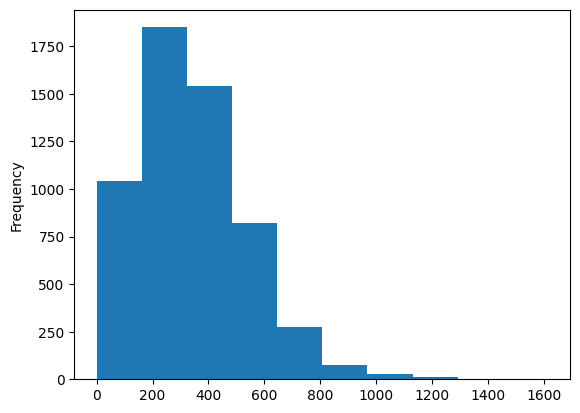

In [4]:
df_copy["len"].plot.hist()

We then plot the frequency of the salaries, to see the distribution of the data. 

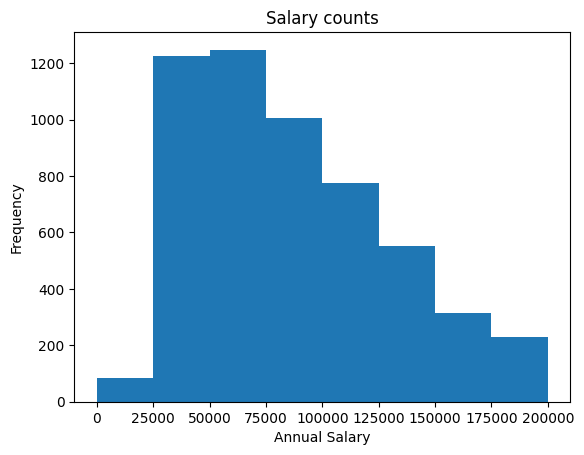

In [5]:
ax = df_copy["annual_salary"].plot.hist(bins=[0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000])
ax.set_xticks([0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000])
plt.xlabel("Annual Salary")
plt.title("Salary counts")
plt.show()

Its clear that a majority of the jobs fall between $25,000 and $75,000 annual salary, so we could consider different technqiues such as downsampling. 

TF-IDF
----
Our first featurization technique is using a TF-IDF Matrix

In [6]:
def tfidf_vectorize_and_split(df, train_size):

    """
        Take a Pandas DataFrame and vectorizes using TF-IDF and splits into training and testing sets

        Parameters:
            df - a DataFrame with a corpus
            train_size - number in [0, 1]

        Returns:
            train/test split of the inputs
    """

    corpus = list(df["description"])
    salaries = list(df["annual_salary"])
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus) 

    print("Vocab size: ", len(tfidf_vectorizer.vocabulary_))

    X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, salaries, random_state=42, train_size=train_size)

    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = tfidf_vectorize_and_split(df, .5)

Vocab size:  56824


Create and fit the model using the training data on a LinearRegression, Ridge and Lasso models

In [8]:
lasso = Lasso()
lasso.fit(X_train, y_train)

Lasso()

In [9]:
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression()

In [10]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

Here we sample predicting some of salaries in the `Lasso` model and compare them

In [11]:
for i in range(5):
    pred = lasso.predict(X_test[i])[0]
    act = y_test[i]
    delta = abs(pred - act)
    print(str(i+1), ": Actual salary - ", str(act), ", Predicted Salary: ", str(pred), ", Delta: ", str(delta))

1 : Actual salary -  51750.0 , Predicted Salary:  35334.25129386529 , Delta:  16415.748706134713
2 : Actual salary -  55000.0 , Predicted Salary:  123446.45036833713 , Delta:  68446.45036833713
3 : Actual salary -  36000.0 , Predicted Salary:  32506.844239897036 , Delta:  3493.1557601029635
4 : Actual salary -  54000.0 , Predicted Salary:  82966.59631619578 , Delta:  28966.596316195777
5 : Actual salary -  36000.0 , Predicted Salary:  39368.897913584995 , Delta:  3368.897913584995


Then we calculate MSE MAE, and the percent of predictions within $5,000 and $10,000 on all three models, on both the training and testing data. This will allow us to analyze our results and check for overfitting.

In [12]:
print("LASSO MODEL")
lasso_preds, mae, mse = utility.predict_and_analyze(lasso, X_test, y_test)
_ = utility.predict_and_analyze(lasso, X_train, y_train)

print("\nLINEAR MODEL")
linear_preds, mae, mse = utility.predict_and_analyze(linear, X_test, y_test)
_ = utility.predict_and_analyze(linear, X_train, y_train)

print("\nRIDGE MODEL")
ridge_preds, mae, mse = utility.predict_and_analyze(ridge, X_test, y_test)
_ = utility.predict_and_analyze(ridge, X_train, y_train)

LASSO MODEL
Mean Squared Error (MSE): 2165543094.016076
Mean Absolute Error: 29603.976933428392
Percent of postings predicted within $5,000:  15.18
Percent of postings predicted within $10,000:  28.33
Mean Squared Error (MSE): 48516722.35254464
Mean Absolute Error: 5219.465006121763
Percent of postings predicted within $5,000:  56.92
Percent of postings predicted within $10,000:  88.47

LINEAR MODEL
Mean Squared Error (MSE): 3100723476.921408
Mean Absolute Error: 37811.241916918094
Percent of postings predicted within $5,000:  13.05
Percent of postings predicted within $10,000:  23.13
Mean Squared Error (MSE): 464793.31292370084
Mean Absolute Error: 27.547382336312477
Percent of postings predicted within $5,000:  99.93
Percent of postings predicted within $10,000:  99.93

RIDGE MODEL
Mean Squared Error (MSE): 1844902259.4512894
Mean Absolute Error: 26201.325999506273
Percent of postings predicted within $5,000:  14.79
Percent of postings predicted within $10,000:  28.09
Mean Squared Er

We can see the `LinearRegression` model is extremely overfit, the `Lasso` model is overfit, and `Ridge` model is a little overfit.

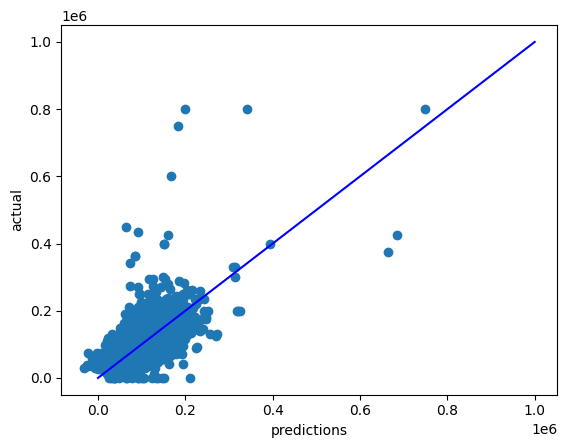

In [13]:
plt.scatter(lasso_preds, y_test)

x = range(0, 1000000)

plt.plot(x, x, c="b")
plt.xlabel('predictions')
plt.ylabel('actual')

plt.show()

As we can see in the plot above, there are many outliers that fall far from the line, and as these numbers are in the six figures, when calculating MSE, the value can become very high, which clearly accounts for the high MSE.


Let's try and use the `coefs` we saved above to extract the most important feautres and retrain the model and compare the scores. Currently we are using 56,824 features, so we will use much smaller sets. 

We will test the affect of the size of the training set on the MAE, and use the value that produces the best results for future tests

In [14]:
def train_size_experiment_with_plot(df): 
    splits = [.4, .5, .6, .7, .8, .9]

    maes = []

    for split in splits:
        X_train, X_test, y_train, y_test = tfidf_vectorize_and_split(df, split)

        lasso = Lasso()
        lasso.fit(X_train, y_train)

        lasso_preds, mae, mse = utility.predict_and_analyze(lasso, X_test, y_test)

        maes.append(mae)

    plt.plot(splits, maes)
        
    plt.xlabel("Percent of training set")
    plt.ylabel("Mean Absolute Error")
    plt.title("Percent Training vs MAE")
    plt.show()

Vocab size:  56824
Mean Squared Error (MSE): 2273806138.7466908
Mean Absolute Error: 29984.514946221127
Percent of postings predicted within $5,000:  15.00
Percent of postings predicted within $10,000:  27.73
Vocab size:  56824
Mean Squared Error (MSE): 2165543094.016076
Mean Absolute Error: 29603.976933428392
Percent of postings predicted within $5,000:  15.18
Percent of postings predicted within $10,000:  28.33
Vocab size:  56824
Mean Squared Error (MSE): 2033803379.4938915
Mean Absolute Error: 28557.80515317688
Percent of postings predicted within $5,000:  14.90
Percent of postings predicted within $10,000:  28.34
Vocab size:  56824
Mean Squared Error (MSE): 1977548280.2643447
Mean Absolute Error: 28793.756069336145
Percent of postings predicted within $5,000:  14.91
Percent of postings predicted within $10,000:  27.58
Vocab size:  56824
Mean Squared Error (MSE): 1618619856.3726556
Mean Absolute Error: 27169.58134430379
Percent of postings predicted within $5,000:  15.92
Percent of 

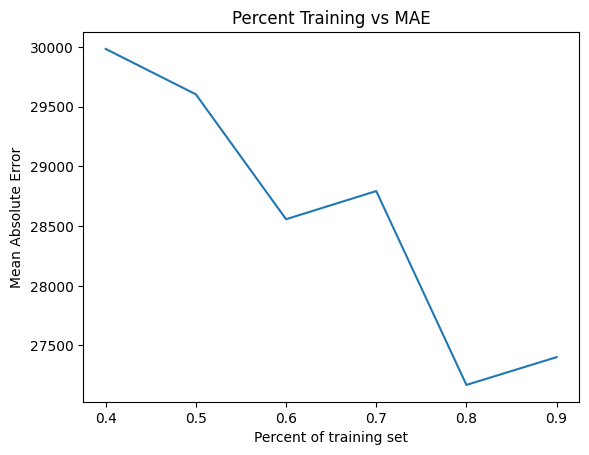

In [15]:
train_size_experiment_with_plot(df)

We will try this again but now after downsampling the data, based on bucket sizes of $25,000. We will limit the data to having 500 data entries in each bucket, and a minimum of 100.

In [16]:
def downsample_bucket(bucket):
    size = len(bucket)

    #print(bucket)
    if size >= 100:
        return bucket.sample(min(500, size), random_state=42)
    else:
        return pd.DataFrame()

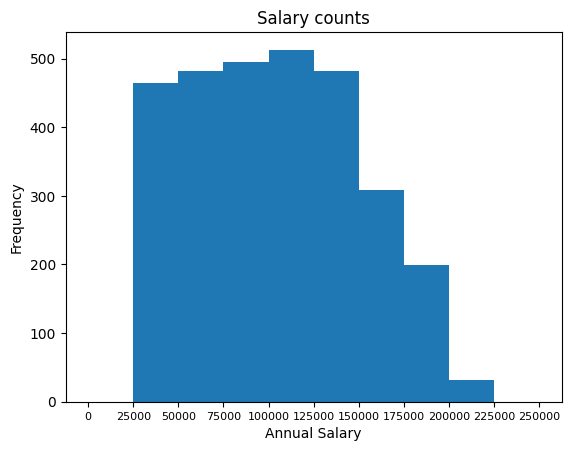

In [17]:
# create the buckets
bucket_size = 25000
bucket_boundaries = list(range(0, int(df['annual_salary'].max()), bucket_size))

# apply the downsampling to the buckets
selected_items = df.groupby(pd.cut(df['annual_salary'], bins=bucket_boundaries)).apply(downsample_bucket)

# extract the remaining descriptions and salaries, and plot the new counts
desc = list(selected_items["description"])
salary = list(selected_items["annual_salary"])

downsample_df = pd.DataFrame(list(zip(desc, salary)), columns=["description", "annual_salary"])

ax = downsample_df["annual_salary"].plot.hist(bins=[0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000, 250000])
ax.set_xticks([0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000, 250000])
plt.xlabel("Annual Salary")
plt.title("Salary counts")
plt.xticks(fontsize=8)
plt.show()

Notice now there is much less outlying data than previously. You may also notice there is a bucket with less than 100, or some that are not exactly 500, although they had much more than that in the original dataset. We have struggled to account for this difference, but the distribution of the data is still far more similar to what we were looking for.

Vocab size:  38935
Mean Squared Error (MSE): 1403472638.676986
Mean Absolute Error: 28823.506533411593
Percent of postings predicted within $5,000:  13.16
Percent of postings predicted within $10,000:  24.97
Vocab size:  38935
Mean Squared Error (MSE): 1367845180.077646
Mean Absolute Error: 28183.39337756035
Percent of postings predicted within $5,000:  14.38
Percent of postings predicted within $10,000:  24.93
Vocab size:  38935
Mean Squared Error (MSE): 1244322318.0907073
Mean Absolute Error: 27289.497002649587
Percent of postings predicted within $5,000:  14.11
Percent of postings predicted within $10,000:  26.87
Vocab size:  38935
Mean Squared Error (MSE): 1178198116.7297947
Mean Absolute Error: 26627.695411934346
Percent of postings predicted within $5,000:  12.88
Percent of postings predicted within $10,000:  27.10
Vocab size:  38935
Mean Squared Error (MSE): 1087950801.0771215
Mean Absolute Error: 25630.547849655337
Percent of postings predicted within $5,000:  13.76
Percent of 

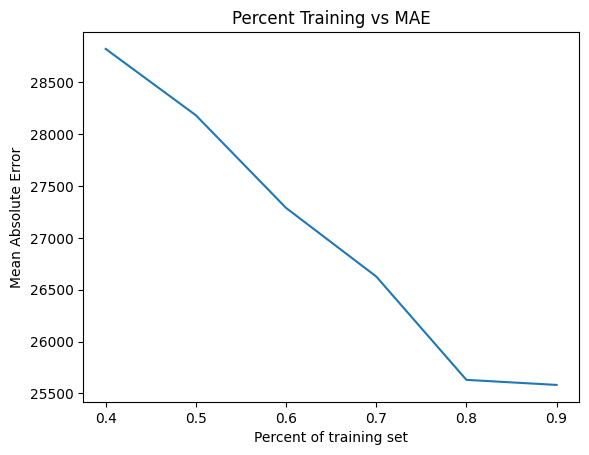

In [18]:
train_size_experiment_with_plot(downsample_df)

The downsampled DataFrame does appear to train more accurately than the original dataset. Getting closer by about $1,500 on average. The future experiments will be run on this downsampled dataset. 

In [19]:
df = downsample_df
corpus = list(df["description"])

In [20]:
file = "data/downsampled_df.csv"
df.to_csv(file)

Experiment using the min_df and max_df parameters in the TfidfVectorizer. Here we will try to eliminate tokens that appear in a large amount of documents, and see how it affects the MAE

In [21]:
# first is default
min_and_max_df = [(1.0, 1), (.60, 1), (.4, 1), (.28, 1), (.25, 1), (.22, 1), (.20, 1), (.18, 1)]

vocab_size = []
maes = []

for n in min_and_max_df:
    temp_corpus = corpus

    tfidf_vectorizer_reduced = TfidfVectorizer(max_df=n[0], min_df=n[1]) 
    tfidf_matrix_reduced = tfidf_vectorizer_reduced.fit_transform(corpus) 

    X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_reduced, list(df["annual_salary"]), random_state=42, train_size=.8)

    model = Lasso()
    model.fit(X_train, y_train)

    print("Testing for ", n, " features")
    _, mae, _ = utility.predict_and_analyze(model, X_test, y_test)

    vocab_size.append(len(tfidf_vectorizer_reduced.vocabulary_))
    maes.append(mae)

Testing for  (1.0, 1)  features
Mean Squared Error (MSE): 1087950801.0771215
Mean Absolute Error: 25630.547849655337
Percent of postings predicted within $5,000:  13.76
Percent of postings predicted within $10,000:  29.36
Testing for  (0.6, 1)  features
Mean Squared Error (MSE): 1091219602.9471378
Mean Absolute Error: 25598.06771069808
Percent of postings predicted within $5,000:  14.43
Percent of postings predicted within $10,000:  29.87
Testing for  (0.4, 1)  features
Mean Squared Error (MSE): 1093817740.321434
Mean Absolute Error: 25805.049185658638
Percent of postings predicted within $5,000:  12.58
Percent of postings predicted within $10,000:  28.19
Testing for  (0.28, 1)  features
Mean Squared Error (MSE): 1080146243.3151212
Mean Absolute Error: 25228.21285525334
Percent of postings predicted within $5,000:  15.44
Percent of postings predicted within $10,000:  29.53
Testing for  (0.25, 1)  features
Mean Squared Error (MSE): 1088418129.6824973
Mean Absolute Error: 25264.349293899

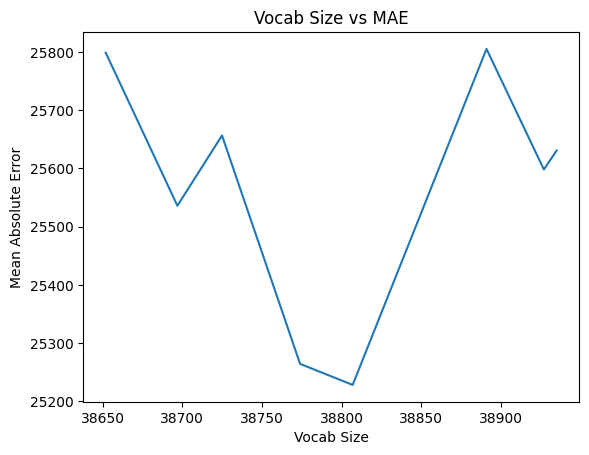

In [22]:
plt.plot(vocab_size, maes)
    
plt.xlabel("Vocab Size")
plt.ylabel("Mean Absolute Error")
plt.title("Vocab Size vs MAE")
plt.show()

Seen in the graph, it appears that only about 300 tokens appear in 18% or more of the documents, but by eliminating these tokens we can achieve some slight improvement in MAE. The best settings we found were (max_df = 0.25, min_df = 1)

Now we will used the most optimal paramters to train and test the model, and display the results

In [33]:
tfidf_vectorizer_reduced = TfidfVectorizer(max_df=.25) 
tfidf_matrix_reduced = tfidf_vectorizer_reduced.fit_transform(corpus) 

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_reduced, list(df["annual_salary"]), random_state=42, train_size=.8)

model = Lasso()
model.fit(X_train, y_train)

joblib.dump(model, 'linear_regression_model.joblib')

preds = model.predict(X_test)

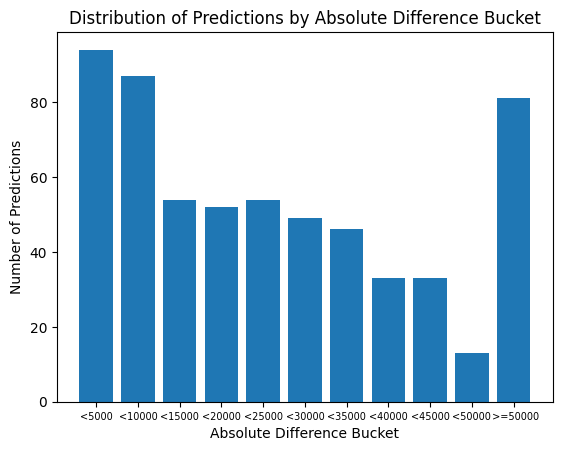

In [30]:
utility.plot_accuracy_in_buckets(y_test, preds)

Bag of Words
----
We will next try to perform the similar strategies above to BoW featurization and see how the predictions compare

In [25]:
def bag_of_words_featurize_and_split(vocab, data, target, max_features = None,):

    # use min_df or max_features?
    vectorizer = CountVectorizer(vocabulary=vocab, binary=True, max_features=max_features)

    X = vectorizer.fit_transform(data)

    X_train, X_test, y_train, y_test = train_test_split(X.toarray(), target, random_state=42, train_size=.8)

    print("Vocab Size: ",len(vectorizer.vocabulary_))

    return X_train, X_test, y_train, y_test


In [26]:
df = pd.read_csv("data/downsampled_df.csv")

df.shape

(2976, 3)

We will experiment with using BoW for our features with different vocab sizes, using the `max_features` parameter in the `CountVectorizer`

In [27]:
number_of_features = [200, 500, 1000, 2000, 5000, 10000, 15000, 20000, 25000, 30000]

maes = []
vocab_size = []

for n in number_of_features:
    X_train, X_test, y_train, y_test = bag_of_words_featurize_and_split(None, list(df["description"]), list(df["annual_salary"]), n)

    model = Lasso() #Lasso?
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    _, mae, _ = utility.predict_and_analyze(model, X_test, y_test)

    maes.append(mae)
    vocab_size.append(X_train.shape[1])

Vocab Size:  200
Mean Squared Error (MSE): 1266141538.8736558
Mean Absolute Error: 29025.587884027937
Percent of postings predicted within $5,000:  8.72
Percent of postings predicted within $10,000:  19.46
Vocab Size:  500
Mean Squared Error (MSE): 1307243988.2308514
Mean Absolute Error: 29146.315633564423
Percent of postings predicted within $5,000:  9.73
Percent of postings predicted within $10,000:  18.62
Vocab Size:  1000


/Users/maxnbf/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.741e+10, tolerance: 4.928e+08
  model = cd_fast.enet_coordinate_descent(


Mean Squared Error (MSE): 1543792958.5047214
Mean Absolute Error: 30944.148189799147
Percent of postings predicted within $5,000:  10.23
Percent of postings predicted within $10,000:  21.31
Vocab Size:  2000


/Users/maxnbf/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.182e+11, tolerance: 4.928e+08
  model = cd_fast.enet_coordinate_descent(


Mean Squared Error (MSE): 5258369154.126584
Mean Absolute Error: 55482.971297246135
Percent of postings predicted within $5,000:  7.05
Percent of postings predicted within $10,000:  13.42
Vocab Size:  5000


/Users/maxnbf/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e+10, tolerance: 4.928e+08
  model = cd_fast.enet_coordinate_descent(


Mean Squared Error (MSE): 2425565299.756968
Mean Absolute Error: 37697.17703142623
Percent of postings predicted within $5,000:  11.41
Percent of postings predicted within $10,000:  20.30
Vocab Size:  10000


/Users/maxnbf/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e+10, tolerance: 4.928e+08
  model = cd_fast.enet_coordinate_descent(


Mean Squared Error (MSE): 2098668816.677985
Mean Absolute Error: 34948.5696648009
Percent of postings predicted within $5,000:  10.57
Percent of postings predicted within $10,000:  20.81
Vocab Size:  15000


/Users/maxnbf/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e+10, tolerance: 4.928e+08
  model = cd_fast.enet_coordinate_descent(


Mean Squared Error (MSE): 2018392387.737897
Mean Absolute Error: 34078.954024962804
Percent of postings predicted within $5,000:  12.92
Percent of postings predicted within $10,000:  23.83
Vocab Size:  20000


/Users/maxnbf/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.659e+10, tolerance: 4.928e+08
  model = cd_fast.enet_coordinate_descent(


Mean Squared Error (MSE): 1890373454.4352975
Mean Absolute Error: 33232.25004684801
Percent of postings predicted within $5,000:  13.42
Percent of postings predicted within $10,000:  21.98
Vocab Size:  25000


/Users/maxnbf/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e+10, tolerance: 4.928e+08
  model = cd_fast.enet_coordinate_descent(


Mean Squared Error (MSE): 1886897743.5405319
Mean Absolute Error: 32917.002924853485
Percent of postings predicted within $5,000:  13.59
Percent of postings predicted within $10,000:  22.82
Vocab Size:  30000
Mean Squared Error (MSE): 1880464979.3686986
Mean Absolute Error: 32740.168135859272
Percent of postings predicted within $5,000:  13.93
Percent of postings predicted within $10,000:  23.66


/Users/maxnbf/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.638e+10, tolerance: 4.928e+08
  model = cd_fast.enet_coordinate_descent(


We plot the relationship between MAE and the vocabulary size

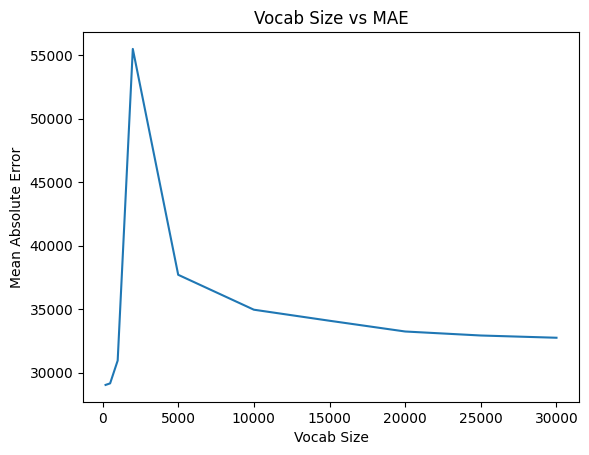

In [28]:
plt.plot(vocab_size, maes)
    
plt.xlabel("Vocab Size")
plt.ylabel("Mean Absolute Error")
plt.title("Vocab Size vs MAE")
plt.show()

We can see that aside from very small vocabularies, as vocabulary increases, MAE decreases.